In [1]:
from utils import imshow, print_pretty
from coco_utils import all_category_names
from generator import BOTR_Generator, generate_name, generate_zipf_description
from postprocessing import sharpen_image
import matplotlib.pyplot as plt
import random

In [3]:
# takes ~34s
botr = BOTR_Generator("dataset/")

loading coco assets - dataset/category_map.pickle
loading coco assets - dataset/coco_organized.pickle
loading coco assets - dataset/annotations/captions_train2017.json
loading annotations into memory...
Done (t=0.95s)
creating index...
index created!


100%|██████████| 0.9940757751464844/0.99 [00:23<00:00, 24.12s/it] 


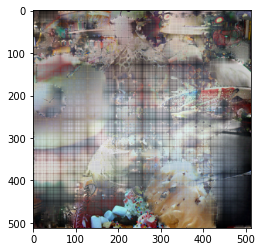

In [10]:
allowedCateg = all_category_names(exclude=['person', 'other'])
allowedCateg = random.sample(allowedCateg, random.randint(1,len(allowedCateg)))
# allowedCateg = ["sky"]

config = {
  # average size of each patch (1 being mean of distribution)
  'avgPatchSize' : 1,
  # average size variance of each patch added
  'avgPatchVariance' : 0.1,
  # minimum area of a patch added, expressed as percentage px after masking
  'minPatchArea' : 0.001, 
  # maximim area of a patch added, expressed as percentage px after masking
  'maxPatchArea' : 0.3, 
  # target percentage of pixels to fill
  'targetFill' : 0.99,
  # output image size
  'outputSize' : (512, 512),
  # prevent supercategories from appearing
  'allowedCategories' : allowedCateg,
  # choose either "stuff_ann" or "instance_ann"
  'ann_key' : "instance_ann",
  # image blending options
  'image_blending' : True,
  'kernel_size' : 3,
  'kernel_sig' : 1.,
  'pyramid_depth': 8,
}

image, metadata = botr.generate_image(config, imageProgress=False)
imshow(image)

In [7]:
_, description = generate_zipf_description(metadata, sentence_len=random.randint(3, 14))
name = generate_name(metadata["category_percentage"])
print(f'{name} : {description}')

0
1
2
3
foodsportsindoorelectronic : Blue snowboards taking library ramp bottle people that a 


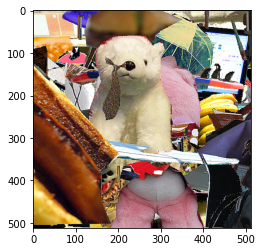

In [8]:
image = sharpen_image(image)
imshow(image)

In [26]:
metadata["name"] = name
metadata["description"] = description

In [27]:
print_pretty(metadata)

{
  "category_percentage": {
    "textile": 0,
    "plant": 0,
    "building": 0,
    "furniture-stuff": 0,
    "structural": 0,
    "raw-material": 0,
    "floor": 0,
    "ceiling": 0,
    "sky": 0,
    "ground": 0,
    "water": 0,
    "food-stuff": 0,
    "solid": 0,
    "wall": 0,
    "window": 0,
    "other": 0,
    "person": 0,
    "vehicle": 0,
    "outdoor": 0,
    "animal": 0,
    "accessory": 0,
    "sports": 0,
    "kitchen": 1.10003662109375,
    "food": 1.6883468627929688,
    "furniture": 0,
    "electronic": 0,
    "appliance": 0,
    "indoor": 1.0318107604980469
  },
  "text_metadata": {
    "objects": [
      "kitchen",
      "food",
      "kitchen",
      "food",
      "food",
      "indoor",
      "food",
      "kitchen",
      "food",
      "indoor",
      "food",
      "kitchen",
      "food",
      "indoor",
      "indoor",
      "indoor",
      "indoor",
      "food",
      "kitchen",
      "kitchen",
      "indoor",
      "indoor",
      "kitchen",
      "food",


In [9]:
image.save(f"generated/{name}.png")

In [12]:
import cv2
from pyramids import blend_masked_rgb, create_kernel
from utils import load_image_cv2, imshow, display_multiple_images
import numpy as np
from scipy.signal import convolve2d

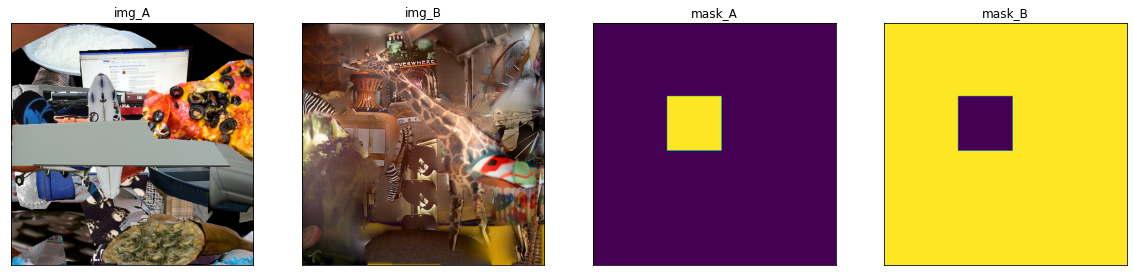

In [9]:
img_A = load_image_cv2("generated/foodelectronicaccessory.png")
img_B = load_image_cv2("generated/furniture.png")
img_B = cv2.resize(img_B, (img_A.shape[0], img_A.shape[1]))

# imshow(img_A, size=(8,8))
# imshow(img_B, size=(8,8))

mask_A = np.zeros((img_A.shape[0], img_A.shape[1], 1))

mask_A[(mask_A.shape[0]//2)-200:(mask_A.shape[0]//2)+30,
    (mask_A.shape[1]//2)-200:(mask_A.shape[1]//2)+30] = 1

mask_B = (mask_A * -1) + 1

# imshow(mask_A, size=(8,8))
# imshow(mask_B, size=(8,8))

display_multiple_images([img_A, img_B, mask_A, mask_B],
['img_A', 'img_B', 'mask_A', 'mask_B'])

In [37]:
from pyramids import generate_pyramid, plot_pyramid_level, reconstruct

def blend_masked(
  img_A, img_B, mask_A, mask_B,
  blendConfig, plot_levels=False):

  print(f'max img a {np.max(img_A)} {img_A.dtype} max img b {np.max(img_B)}')
  pyrKernel = create_kernel(
    blendConfig['pyr_kernel_size'], blendConfig['pyr_kernel_sigma'])

  maskKernel = create_kernel(
    blendConfig['mask_kernel_size'], blendConfig['mask_kernel_sigma'])

  img1_G, img1_L = generate_pyramid(img_A, pyrKernel, blendConfig['max_depth'])
  _,      img2_L = generate_pyramid(img_B, pyrKernel, blendConfig['max_depth'])

  blended_L = []
  # reverse order of pyramid
  img1_L = img1_L[::-1]
  img2_L = img2_L[::-1]

  # iterate through levels and blend spatial frequencies
  for l_1, l_2 in zip(img1_L, img2_L):

    mask_A_scaled = cv2.resize(mask_A, (l_1.shape[0], l_1.shape[1]))
    mask_B_scaled = cv2.resize(mask_B, (l_2.shape[0], l_2.shape[1]))
    
    if blendConfig['blur_masks']:
      mask_A_scaled = convolve2d(
        mask_A_scaled, maskKernel, mode='same', boundary='wrap')
      mask_B_scaled = convolve2d(
        mask_B_scaled, maskKernel, mode='same', boundary='wrap')

    l_1 *= mask_A_scaled
    l_2 *= mask_B_scaled
    
    blend = l_1+l_2
    # blend = (blend - np.min(blend)) / ((np.max(blend) - np.min(blend)) + 1e-7)
    blended_L.append(blend)

    if plot_levels:
      display_multiple_images([l_1, l_2, mask_A_scaled, mask_B_scaled, blend],
                      ['l_1', 'l_2', 'mask_A', 'mask_B', 'blended'])
 
  blended_L = blended_L[::-1]
  recon = reconstruct(img1_G[-1], blended_L, pyrKernel)
  return recon

def normalize_values(values):
  values = (values - np.min(values)) / (np.max(values) - np.min(values))
  return values

def scale_value_range(image, to_float=True):
  if to_float:
    image = image.astype(float)
    if np.max(image) > 1.:
      image = np.clip(image / 255, 0., 1.)
  else:
    if np.max(image) <= 1:
      image = np.clip(image * 255, 0, 255)
    image = image.astype(np.uint8)
  return image

def to_float_range(values)
  image = values.astype(float)
  if np.max(image) > 1.:
    image = np.clip(image / 255, 0., 1.)
  

def blend_masked_rgb(img_A, img_B, 
  mask_A, mask_B, blendConfig):

  img_A = scale_value_range(img_A, to_float=True)
  img_B = scale_value_range(img_B, to_float=True)

  blended_rgb = []
  for channel in range(3):
    plot_levels = False
    if channel==0:
      plot_levels=True
    blended = blend_masked(
        img_A[:,:,channel], img_B[:,:,channel], 
        mask_A, mask_B, blendConfig, 
        plot_levels=plot_levels)
          
    blended_rgb.append(blended)

  blended_rgb = np.stack(blended_rgb, axis=-1)
  blended_rgb = normalize_values(blended_rgb)
  
  # blended_rgb = scale_value_range(blended_rgb, to_float=False)

  return blended_rgb

max img a 1.0 float64 max img b 1.0


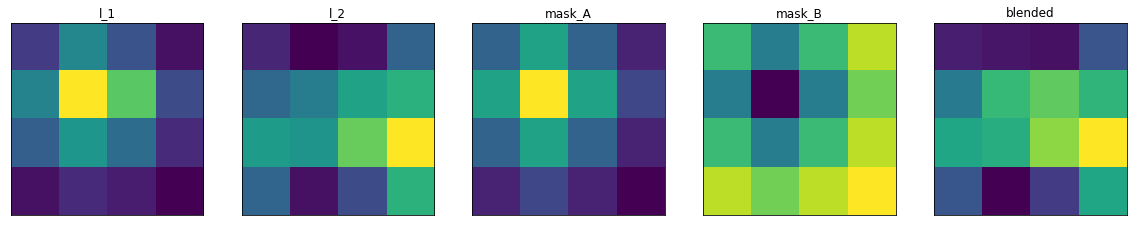

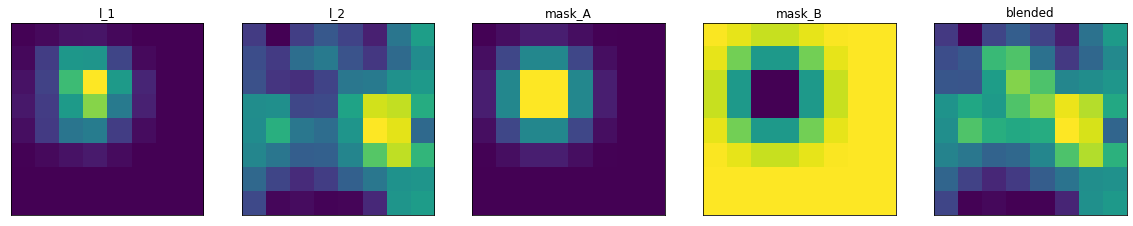

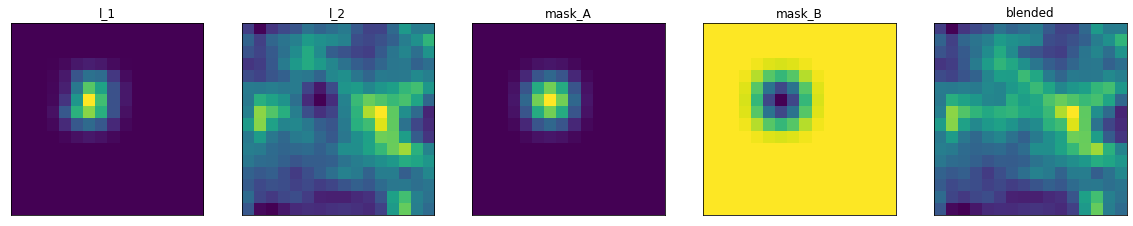

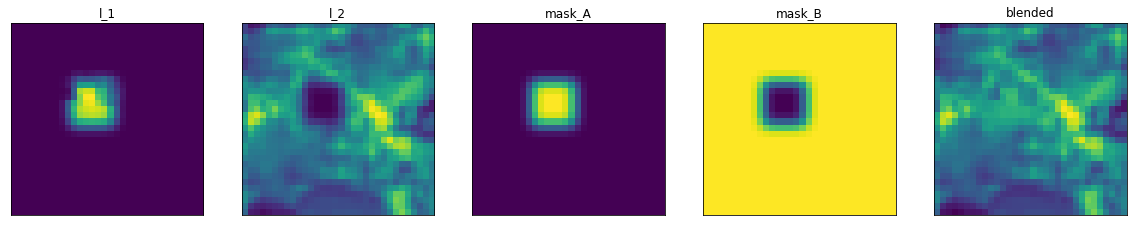

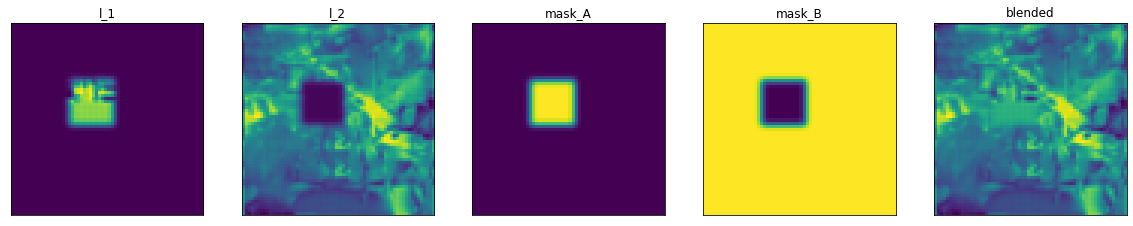

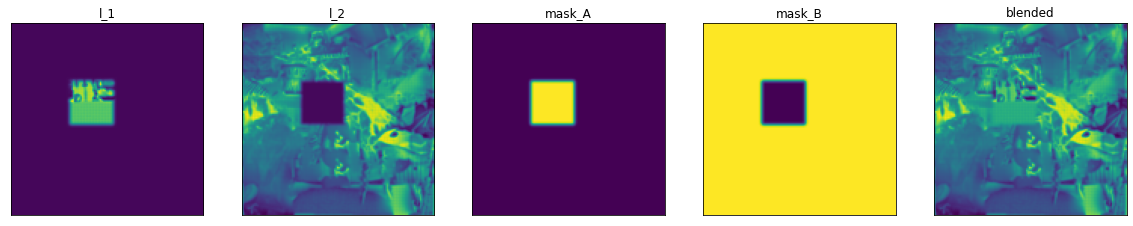

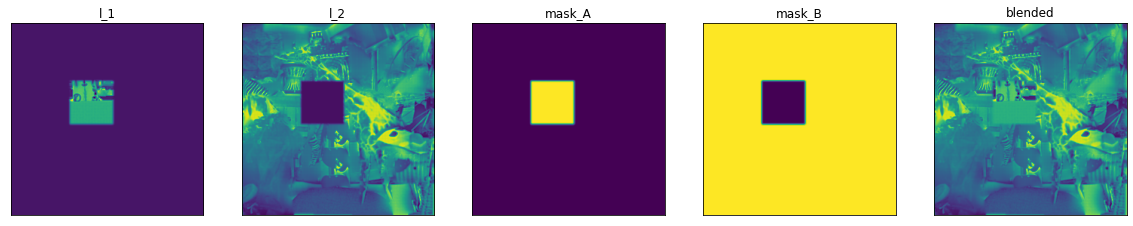

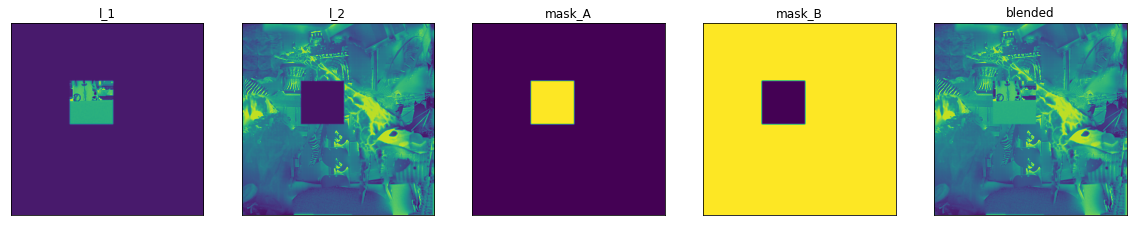

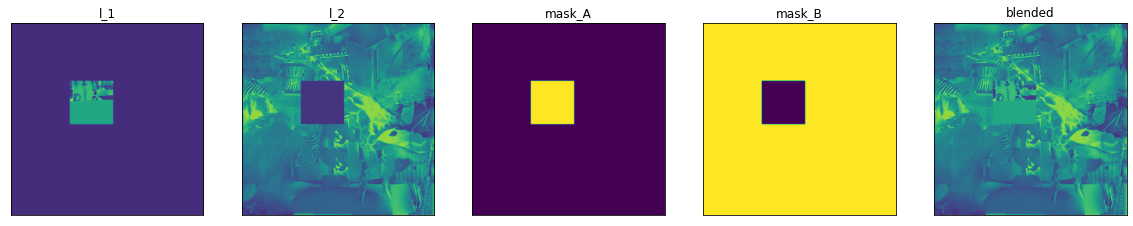

max img a 1.0 float64 max img b 1.0
max img a 1.0 float64 max img b 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.0115905756780212


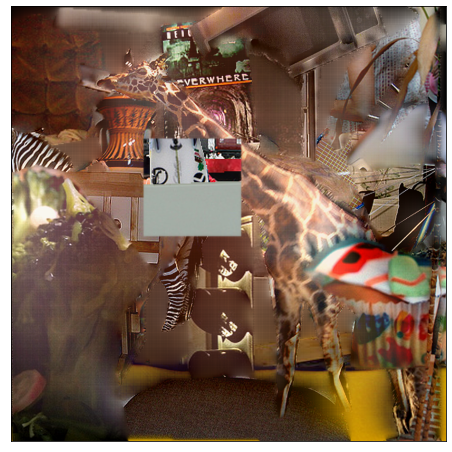

In [38]:
blendConfig = {
  "pyr_kernel_size" : 5,
  "pyr_kernel_sigma" : 1.,
  "mask_kernel_size" : 5,
  "mask_kernel_sigma" : 1.,
  "max_depth" : None,
  "blur_masks" : True
}

blended = blend_masked_rgb(
    img_A=img_A,
    img_B=img_B,
    mask_A=mask_A,
    mask_B=mask_B,
    blendConfig=blendConfig
)

print(np.max(blended))
imshow(blended, size=(8,8))

In [40]:
print(np.max(blended), np.min(blended))

1.0115905756780212 -0.001681232071686578


0.1591549413887541


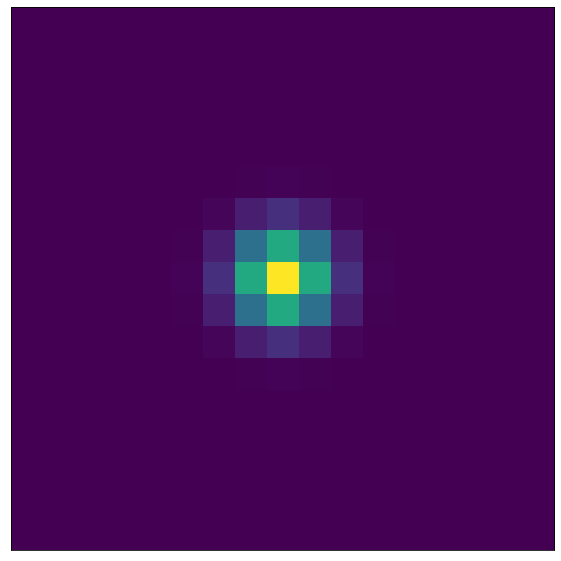

In [14]:
kernel = create_kernel(17, 1)
print(np.max(kernel))
imshow(kernel)